In [1]:
#/usr/bin/env python
#coding=utf-8
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from matplotlib import pyplot as plt
from PIL import Image
import cv2
from importlib import reload
import Face_alignment_pak as face
from importlib import reload
import cv2

In [2]:
# import torchsummary
#epoch 100, lr, 0.1 and uopdate, batch 256

num_classes  = 9
batchsize = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
class newresnet(torch.nn.Module):
    def __init__(self):
        super(newresnet, self).__init__()

        self.newresnet18  = torchvision.models.resnet18(pretrained = True)
        # for param in self.newresnet18.parameters():
        #     param.requires_grad = False
        # here in_feature is 512*block.expansion
        num_ftrs = self.newresnet18.fc.in_features 

        # remove the last fc layer
        # myresnet = torch.nn.Sequential(*list(myresnet.children())[:-1])
        self.newresnet18.fc = torch.nn.Identity()
        self.fc = torch.nn.Linear(num_ftrs, num_classes)
    def forward(self,x):
        x = self.newresnet18(x)
        # x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [11]:
# predict
def predict(model, loader):
    model.to(device)
    #model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_predicted = []
        labels_total = []
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)# _ are max values, predicts are their indexs
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted += predicted.cpu().numpy().tolist()
            labels_total += labels.cpu().numpy().tolist()
            
            
#             if predicted == labels and int(labels)==1:
#                 print(images.to('cpu'))
#                 print(outputs)
#                 print(_, predicted)
#                 plt.imshow(images.to('cpu').squeeze().permute(1,2,0))
#                 print(labels)
#                 break
            
           
        print("Accuracy: {}%" .format(100* correct/total))
    #model.train()
    return all_predicted, labels_total

In [77]:
#source : https://stackoverflow.com/questions/54607447/opencv-how-to-overlay-text-on-videos
def draw_label(img, text, pos, bg_color):
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    scale = 4
    color = (255, 255, 0)
    thickness = cv2.FILLED
    thickness = 10
    margin = 20

    txt_size = cv2.getTextSize(text, font_face, scale, thickness)

    end_x = pos[0] + txt_size[0][0] + margin
    end_y = pos[1] - txt_size[0][1] - margin

    #cv2.rectangle(img, pos, (end_x, end_y), bg_color, thickness)
    cv2.putText(img, text, pos, font_face, scale, color, 10, cv2.LINE_AA)

In [13]:
# for loading
myresnet = newresnet()# (use the class to initialize the model)
myresnet.to(device)
myresnet.eval()
fname = "C:/Users/ZXY/Desktop/ASU/ProgramCourses/2020spring/EEE511/HW/Final/myresnet3.pt"
myresnet.load_state_dict(torch.load(fname))

<All keys matched successfully>

In [14]:
idx_sentiment = {0: 'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'neutral', 5:'sad', 6:'surprise'}

In [15]:
#required size Resnet 224, 224
#              Inception v3 N x 3 x 299 x 299
resize  = torchvision.transforms.Resize((224, 224))
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])## need mean and std
preprocessor = torchvision.transforms.Compose([ 

                                               resize,
                                               torchvision.transforms.ToTensor(), 
                                               normalize,
                                               ])
preprocessor2 = torchvision.transforms.Compose([ 

                                               resize,
                                               torchvision.transforms.ToTensor(), 
                                               ])
#                                               torchvision.transforms.RandomRotation(20),
#                                              torchvision.transforms.RandomHorizontalFlip(),
#preprocessor = torchvision.transforms.Compose([resize, torchvision.transforms.ToTensor()])

#load train data
#data_dir = '../../data/'
#data_dir = '/System/Volumes/Data/data/'
#root/dog/xxx.png
# root/cat/123.png

In [16]:
path = r'C:\Users\ZXY\Desktop\ASU\ProgramCourses\2020spring\EEE511\HW\Final\dataset1'

#load test data
data_dir_test = path + r'\test'
test_dataset = torchvision.datasets.ImageFolder(root = data_dir_test,
                                               transform = preprocessor)
print('test_dataset size:', len(test_dataset))

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batchsize,
                                          shuffle = False)
print('test_loader size:', len(test_loader))

test_dataset size: 74
test_loader size: 74


Accuracy: 20.27027027027027%


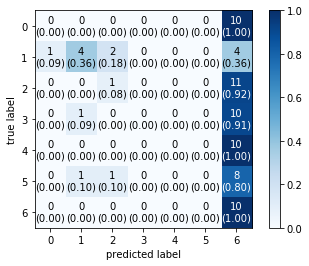

In [17]:

test_predicts, test_labels = predict(myresnet, test_loader)
cm = metrics.confusion_matrix(test_labels, test_predicts)

fig,ax = plot_confusion_matrix(cm, colorbar = True, show_normed = True)
plt.show()

In [25]:
path2 = r'C:\Users\ZXY\Desktop\ASU\ProgramCourses\2020spring\EEE511\HW\Final\dataset_test_2'


#load test data
data_dir_test2 = path2 + r'\test'
test_dataset2 = torchvision.datasets.ImageFolder(root = data_dir_test2,
                                               transform = preprocessor)
print('test_dataset2 size:', len(test_dataset2))

test_loader2 = torch.utils.data.DataLoader(dataset = test_dataset2,
                                          batch_size = 1,
                                          shuffle = False)
print('test_loader2 size:', len(test_loader2))


test_dataset2 size: 1
test_loader2 size: 1


In [26]:
for images, labels in test_loader2:
    test_img = images
    test_label = labels
    break
print(test_img.shape)

torch.Size([1, 3, 224, 224])


4 neutral


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


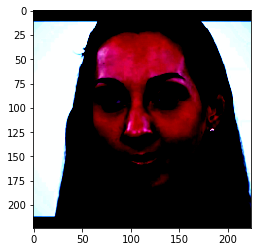

In [32]:
myresnet.eval()
predict_outputs = myresnet.forward(test_img.to(device))
_, predicted = torch.max(predict_outputs.data, 1)# _ are max values, predicts are their indexs

sentiment = idx_sentiment[int(predicted[0])]
print(int(predicted[0]), sentiment)
plt.imshow(test_img.squeeze().permute(1,2,0))


In [37]:
test_img.shape

torch.Size([1, 3, 224, 224])

torch.Size([1800, 1800, 3])
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 fear


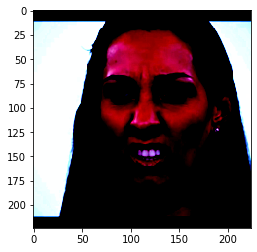

In [45]:

myresnet.eval()
reload(face)
path = "C:\\Users\\ZXY\\Desktop\\ASU\\ProgramCourses\\2020spring\\EEE511\\HW\\Final\\video_frame_test\\test600.jpg"
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# pay attention here, effect predication
#new_img = face.face_alig(img)
#img = img[:,:,::-1]
Face_frame = torch.from_numpy(img).float()

print(Face_frame.shape)
Face_frame = preprocessor(Image.fromarray(img))
print(Face_frame.shape)
plt.imshow(Face_frame.squeeze().permute(1,2,0))
predict_outputs = myresnet.forward(Face_frame.unsqueeze(0).to(device))
_, predicted = torch.max(predict_outputs.data, 1)# _ are max values, predicts are their indexs

sentiment = idx_sentiment[int(predicted[0])]
print(int(predicted[0]), sentiment)


In [35]:
predict_outputs

tensor([[ 3.2817, -1.3326,  2.1629, -1.0124,  0.5379,  0.3618,  4.6628, -3.6328,
         -5.1844]], device='cuda:0', grad_fn=<AddmmBackward>)

In [81]:
import cv2
from importlib import reload
reload(face)
# Opens the Video file
video_path = "C:\\Users\\ZXY\\Desktop\\ASU\\ProgramCourses\\2020spring\\EEE511\\HW\\Final\\test\\test3.avi"
capture= cv2.VideoCapture(video_path)

# Define the codec and create VideoWriter object
frame_width = int(capture.get(3))
frame_height = int(capture.get(4))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.mp4',fourcc, 60.0, (frame_width,frame_height))

i=0
sentiment = []
while(capture.isOpened()):
    ret, frame = capture.read()
    if ret == False:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    if i == 0 or i%30 == 0:
        
        #Face_frame = face.face_alig(frame)
        Face_frame = torch.from_numpy(frame).float()

        Face_frame = preprocessor(Image.fromarray(frame))
        
        myresnet.eval()
        predict_outputs = myresnet.forward(Face_frame.unsqueeze(0).to(device))
        _, predicted = torch.max(predict_outputs.data, 1)# _ are max values, predicts are their indexs
    
        sentiment = idx_sentiment[int(predicted[0])]
        print(i, sentiment)

    # draw the label into the frame
    draw_label(frame, sentiment, (40,240), (0,255,255))
    
    i+=1
    if i > 300 and i<1200:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame)

    
    if i==10000:
        print(i)
        break

capture.release()
out.release()

cv2.destroyAllWindows()


0 fear
30 fear
60 fear
90 fear
120 fear
150 fear
180 disgust
210 surprise
240 surprise
270 surprise
300 neutral
330 neutral
360 sad
390 sad
420 sad
450 sad
480 surprise
510 fear
540 angry
570 angry
600 fear
630 fear
660 angry
690 angry
720 angry
750 angry
780 angry
810 happy
840 happy
870 happy
900 happy
930 happy
960 surprise
990 surprise
1020 surprise
1050 surprise
1080 surprise
1110 surprise
1140 surprise
1170 surprise
1200 surprise
1230 surprise
1260 surprise
1290 angry
1320 fear
1350 fear
1380 fear
1410 fear
1440 fear
1470 fear
1500 fear
